https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

# DOG AND CAT 데이터 셋 다운로드

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary

import PIL
import shutil
import zipfile
import glob
import os
import time

In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_zip_dir = './dataset/dogs-vs-cats-redux-kernels-edition'
train_zip_dir = os.path.join(data_zip_dir, 'train.zip')
test_zip_dir = os.path.join(data_zip_dir, 'test.zip')

"""
압축 해제 

with zipfile.ZipFile(train_zip_dir, 'r') as z:
    z.extractall()
with zipfile.ZipFile(test_zip_dir, 'r') as z:
    z.extractall()
"""
train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')

 
train_set_dir = os.path.join(train_dir, 'train')
valid_set_dir = os.path.join(train_dir, 'valid')
test_set_dir = os.path.join(train_dir, 'test')

dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

print('set folders')
"""
train / test 폴더 생성 

train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')
 
train_set_dir = os.path.join(train_dir, 'train')
os.mkdir(train_set_dir)
valid_set_dir = os.path.join(train_dir, 'valid')
os.mkdir(valid_set_dir)
test_set_dir = os.path.join(train_dir, 'test')
os.mkdir(test_set_dir)
 
dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]

for dog, cat in zip(dog_files[:10000], cat_files[:10000]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(train_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(train_set_dir, cat)
    shutil.move(src, dst)
    
for dog, cat in zip(dog_files[10000:11250], cat_files[10000:11250]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(valid_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(valid_set_dir, cat)
    shutil.move(src, dst)
    
for dog, cat in zip(dog_files[11250:12500], cat_files[11250:12500]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(test_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(test_set_dir, cat)
    shutil.move(src, dst)
"""

set folders


"\ntrain / test 폴더 생성 \n\ntrain_dir = os.path.join(os.getcwd(), 'train')\ntest_dir = os.path.join(os.getcwd(), 'test')\n \ntrain_set_dir = os.path.join(train_dir, 'train')\nos.mkdir(train_set_dir)\nvalid_set_dir = os.path.join(train_dir, 'valid')\nos.mkdir(valid_set_dir)\ntest_set_dir = os.path.join(train_dir, 'test')\nos.mkdir(test_set_dir)\n \ndog_files = [f'dog.{i}.jpg' for i in range(12500)]\ncat_files = [f'cat.{i}.jpg' for i in range(12500)]\n\nfor dog, cat in zip(dog_files[:10000], cat_files[:10000]):\n    src = os.path.join(train_dir, dog)\n    dst = os.path.join(train_set_dir, dog)\n    shutil.move(src, dst)\n    src = os.path.join(train_dir, cat)\n    dst = os.path.join(train_set_dir, cat)\n    shutil.move(src, dst)\n    \nfor dog, cat in zip(dog_files[10000:11250], cat_files[10000:11250]):\n    src = os.path.join(train_dir, dog)\n    dst = os.path.join(valid_set_dir, dog)\n    shutil.move(src, dst)\n    src = os.path.join(train_dir, cat)\n    dst = os.path.join(valid_set_dir,

In [108]:


print(f'the number of train set : {len(os.listdir(train_set_dir))}')
print(f'the number of validn set : {len(os.listdir(valid_set_dir))}')
print(f'the number of test set : {len(os.listdir(test_set_dir))}')

the number of train set : 20000
the number of validn set : 2500
the number of test set : 2500


데이터셋 Class 구현

In [109]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'cat' in files[0]:
            self.label = 0
        else:
            self.label = 1
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

In [110]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])

train_dog_dataset = CustomDataset(dog_files[:10000], train_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:10000], train_set_dir, transform=train_transform)
valid_dog_dataset = CustomDataset(dog_files[10000:11250], valid_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[10000:11250], valid_set_dir, transform=test_transform)
test_dog_dataset = CustomDataset(dog_files[11250:], test_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[11250:], test_set_dir, transform=test_transform)
 
train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])


print(f'number of train dataset : {len(train_dataset)}')
print(f'number of valid dataset : {len(valid_dataset)}')
print(f'number of test dataset : {len(test_dataset)}')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


number of train dataset : 20000
number of valid dataset : 2500
number of test dataset : 2500


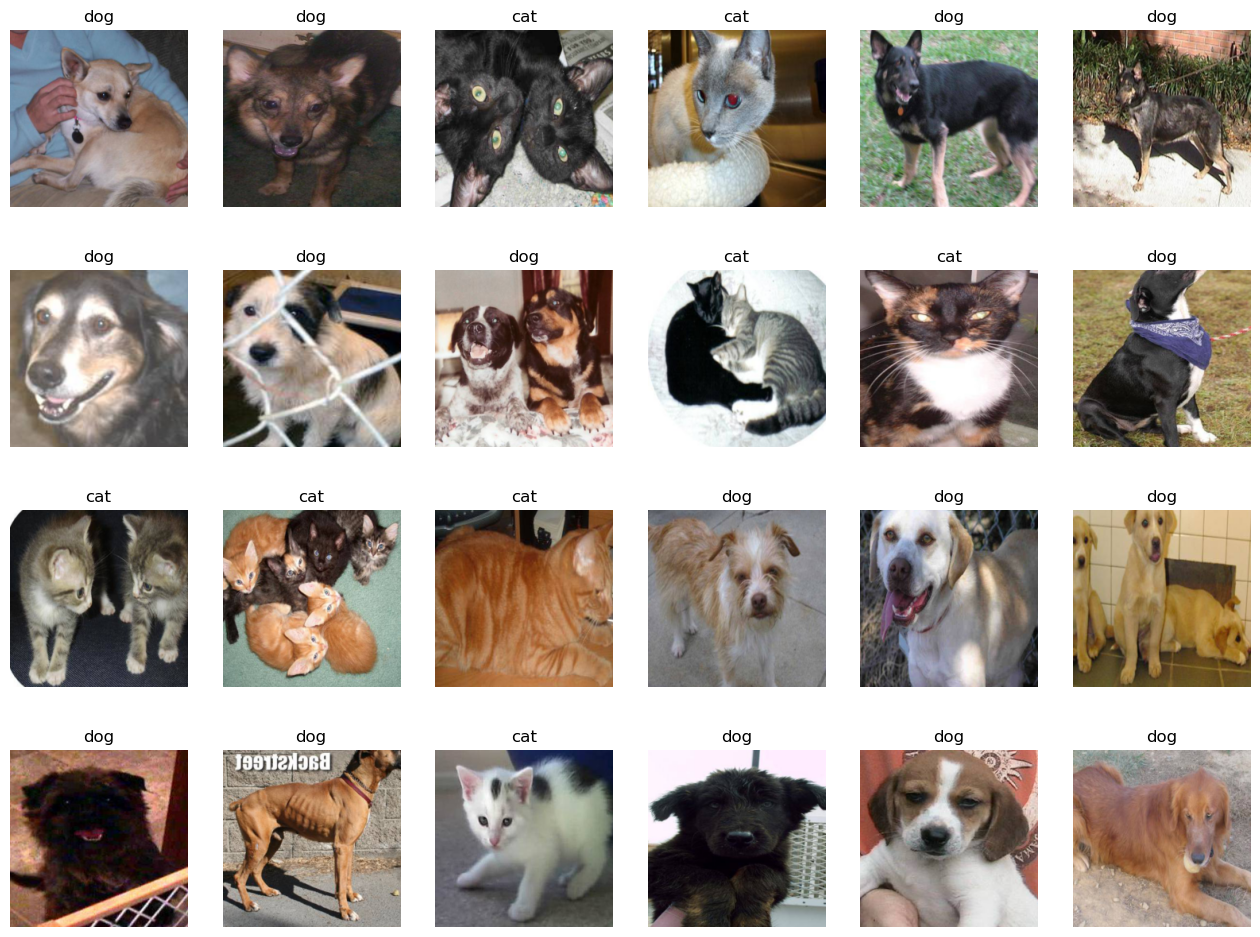

In [111]:
samples, labels = iter(train_loader).__next__()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


In [112]:
model = torchvision.models.resnet50(pretrained=True)

c:\Users\kde96\.conda\envs\PyeonHaeng\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kde96\.conda\envs\PyeonHaeng\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [113]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 